In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import torch
import torch.nn as nn
import torch.nn.functional as F
import geopy
from torch.utils import data
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)

In [2]:
# Data read
df_rentals = pd.read_csv("./data/Rentals_2019-4-2_1456.csv", parse_dates=[0,1])
df_hubs = pd.read_csv("./data/Hubs_2019-4-2_1201.csv", parse_dates=[0,-1])

In [3]:
# Centered location (latitude, longitude) which we will use in all our following plots
# Copenhagen center
initial_location = [55.6775757, 12.579571639999999]
# Nordhavn 55.7047,12.5909
# Osterport 55.6925,12.5864
# Norreport 55.6831,12.5714
# Kongens Nytorv 55.6793,12.5856
# Tivoli 55.67334,12.56887
# Christianshavn 55.6719,12.5919
# Amagerbro 55.6630,12.6032
# Teglholmen 55.6505,12.5515
# Norrebros Rundel 55.69434,12.54882
# Dybbolsbro 55.6645,12.5596
# Valby 55.66353,12.51351

# Cluster radius in meters
cluster_radius = 650

In [4]:
# Display clusters
user_map = folium.Map(location=initial_location, zoom_start=13)

clusters = [
            ('Nordhavn', (55.7047, 12.5909)), ('Osterport', (55.6925, 12.5864)),
            ('Norreport', (55.6831, 12.5714)), ('Kongens Nytorv', (55.6793, 12.5856)),
            ('Tivoli', (55.67334, 12.56887)), ('Christianshavn', (55.6719, 12.5919)),
            ('Amagerbro', (55.6630, 12.6032)), ('Teglholmen', (55.6505, 12.5515)),
            ('Norrebros Rundel', (55.69434,12.54882)), ('Dybbolsbro', (55.6645,12.5596)),
            ('Valby', (55.66353,12.51351))
           ]

for cluster in clusters:
    folium.Circle(
        location=cluster[1],
        radius=cluster_radius,
        popup='Cluster_{}'.format(cluster[0]),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(user_map)
    
# for point in range(0, len(locationlist[:450])):
#     folium.CircleMarker(
#     location=[df_hubs[df_hubs.id == int(locationlist[point][0])]['latitude'].values[0],df_hubs[df_hubs.id == int(locationlist[point][0])]['longitude'].values[0]],
#     radius=3,
#     popup='Rental_{}'.format(point),
#     color='#3186cc',
#     fill=True,
#     fill_color='#3186cc').add_to(user_map)
    
#     folium.CircleMarker(
#     location=[df_hubs[df_hubs.id == int(locationlist[point][1])]['latitude'].values[0],df_hubs[df_hubs.id == int(locationlist[point][1])]['longitude'].values[0]],
#     radius=3,
#     popup='Rental_{}'.format(point),
#     color='crimson',
#     fill=True,
#     fill_color='crimson').add_to(user_map)

# user_map

user_map

In [5]:
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]
        return X, y

In [6]:
# Rentals mapped to location (latitude, longitude)
limited_rentals = df_rentals[df_rentals.pickup_hub_id.notnull()]
limited_rentals = limited_rentals.sort_values(by=['created_at'])
limited_rentals = limited_rentals.head(5000)
limited_rentals

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id
13350,2018-03-01 08:12:40.421178,2018-03-02 16:53:12.023000,2164,2258.0,19880
834,2018-03-01 08:31:29.018673,2018-03-01 15:25:49.782000,1198,1198.0,108925
11122,2018-03-01 10:25:34.427486,2018-03-02 20:23:21.929000,2337,2337.0,107104
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544000,2337,2337.0,113822
836,2018-03-01 10:50:10.437263,2018-03-02 10:09:02.697000,1736,1736.0,3786
...,...,...,...,...,...
1814,2018-04-14 11:12:27.358656,2018-04-15 11:07:05.761006,2165,1520.0,124588
3735,2018-04-14 11:12:27.747247,2018-04-15 11:06:11.394687,2215,1520.0,124587
3680,2018-04-14 11:16:57.620211,2018-04-14 15:42:29.187564,924,924.0,124247
15359,2018-04-14 11:21:01.170876,2018-04-14 14:46:51.111310,2212,2451.0,123927


In [7]:
# Merge pickups
rentals_location = limited_rentals.merge(df_hubs, how='left', left_on='pickup_hub_id', right_on='id')
rentals_location.drop(['name', 'deleted_at', 'id', 'created_at_y'], axis=1, inplace=True)
rentals_location.rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude', 'created_at_x': 'created_at'}, inplace=True)
rentals_location = rentals_location[rentals_location.pickup_latitude.notnull() & rentals_location.pickup_longitude.notnull()]
rentals_location

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_latitude,pickup_longitude
0,2018-03-01 08:12:40.421178,2018-03-02 16:53:12.023000,2164,2258.0,19880,55.674842,12.564927
1,2018-03-01 08:31:29.018673,2018-03-01 15:25:49.782000,1198,1198.0,108925,55.705371,12.580966
2,2018-03-01 10:25:34.427486,2018-03-02 20:23:21.929000,2337,2337.0,107104,55.670289,12.565058
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544000,2337,2337.0,113822,55.670289,12.565058
4,2018-03-01 10:50:10.437263,2018-03-02 10:09:02.697000,1736,1736.0,3786,55.672389,12.563767
...,...,...,...,...,...,...,...
4995,2018-04-14 11:12:27.358656,2018-04-15 11:07:05.761006,2165,1520.0,124588,55.674808,12.569263
4996,2018-04-14 11:12:27.747247,2018-04-15 11:06:11.394687,2215,1520.0,124587,55.676256,12.569712
4997,2018-04-14 11:16:57.620211,2018-04-14 15:42:29.187564,924,924.0,124247,55.694326,12.548629
4998,2018-04-14 11:21:01.170876,2018-04-14 14:46:51.111310,2212,2451.0,123927,55.662539,12.604024


In [8]:
# Merge dropoffs
start = time.time()
rentals_location = rentals_location.merge(df_hubs, how='left', left_on='dropoff_hub_id', right_on='id')
rentals_location.drop(['name', 'deleted_at', 'id', 'created_at_y'], axis=1, inplace=True)
rentals_location.rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude', 'created_at_x': 'created_at'}, inplace=True)
rentals_location = rentals_location[rentals_location.dropoff_latitude.notnull() & rentals_location.dropoff_longitude.notnull()]
end = time.time()
print("Merge took: {}s".format(end - start))
rentals_location

Merge took: 0.014641523361206055s


,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2018-03-01 08:12:40.421178,2018-03-02 16:53:12.023000,2164,2258.0,19880,55.674842,12.564927,55.673425,12.550245
1,2018-03-01 08:31:29.018673,2018-03-01 15:25:49.782000,1198,1198.0,108925,55.705371,12.580966,55.705371,12.580966
2,2018-03-01 10:25:34.427486,2018-03-02 20:23:21.929000,2337,2337.0,107104,55.670289,12.565058,55.670289,12.565058
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544000,2337,2337.0,113822,55.670289,12.565058,55.670289,12.565058
4,2018-03-01 10:50:10.437263,2018-03-02 10:09:02.697000,1736,1736.0,3786,55.672389,12.563767,55.672389,12.563767
...,...,...,...,...,...,...,...,...,...
4864,2018-04-14 11:12:27.358656,2018-04-15 11:07:05.761006,2165,1520.0,124588,55.674808,12.569263,55.677285,12.577430
4865,2018-04-14 11:12:27.747247,2018-04-15 11:06:11.394687,2215,1520.0,124587,55.676256,12.569712,55.677285,12.577430
4866,2018-04-14 11:16:57.620211,2018-04-14 15:42:29.187564,924,924.0,124247,55.694326,12.548629,55.694326,12.548629
4867,2018-04-14 11:21:01.170876,2018-04-14 14:46:51.111310,2212,2451.0,123927,55.662539,12.604024,55.659934,12.607912


In [9]:
# print(rentals_location.iloc[0].pickup_latitude)
# print(rentals_location.iloc[0].pickup_longitude)
import geopy.distance
start = time.time()
for index, row in rentals_location.iterrows():
    coords = (row.pickup_latitude, row.pickup_longitude)
    distances = np.zeros((len(clusters)))
    for cluster_index in range(len(clusters)):
        distance = geopy.distance.distance(coords, clusters[cluster_index][1])
        distances[cluster_index] = distance.km
    cluster_arg = np.argmin(distances)
    rentals_location.loc[index, 'pickup_cluster'] = cluster_arg
    
    coords = (row.dropoff_latitude, row.dropoff_longitude)
    distances = np.zeros((len(clusters)))
    for cluster_index in range(len(clusters)):
        distance = geopy.distance.distance(coords, clusters[cluster_index][1])
        distances[cluster_index] = distance.km
    cluster_arg = np.argmin(distances)
    rentals_location.loc[index, 'dropoff_cluster'] = cluster_arg
end = time.time()
print("Cluster location took: {}s".format(end-start))
rentals_location

Cluster location took: 23.183103799819946s


,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_cluster,dropoff_cluster
0,2018-03-01 08:12:40.421178,2018-03-02 16:53:12.023000,2164,2258.0,19880,55.674842,12.564927,55.673425,12.550245,4.0,9.0
1,2018-03-01 08:31:29.018673,2018-03-01 15:25:49.782000,1198,1198.0,108925,55.705371,12.580966,55.705371,12.580966,0.0,0.0
2,2018-03-01 10:25:34.427486,2018-03-02 20:23:21.929000,2337,2337.0,107104,55.670289,12.565058,55.670289,12.565058,4.0,4.0
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544000,2337,2337.0,113822,55.670289,12.565058,55.670289,12.565058,4.0,4.0
4,2018-03-01 10:50:10.437263,2018-03-02 10:09:02.697000,1736,1736.0,3786,55.672389,12.563767,55.672389,12.563767,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
4864,2018-04-14 11:12:27.358656,2018-04-15 11:07:05.761006,2165,1520.0,124588,55.674808,12.569263,55.677285,12.577430,4.0,3.0
4865,2018-04-14 11:12:27.747247,2018-04-15 11:06:11.394687,2215,1520.0,124587,55.676256,12.569712,55.677285,12.577430,4.0,3.0
4866,2018-04-14 11:16:57.620211,2018-04-14 15:42:29.187564,924,924.0,124247,55.694326,12.548629,55.694326,12.548629,8.0,8.0
4867,2018-04-14 11:21:01.170876,2018-04-14 14:46:51.111310,2212,2451.0,123927,55.662539,12.604024,55.659934,12.607912,6.0,6.0


In [10]:
# Write coordinated data to file
# rentals_location.to_csv('head120k')
parse_dates = ['created_at', 'finished_at']
rentals_location = pd.read_csv('head120k', parse_dates=parse_dates)
# rentals_location

In [11]:
# number_of_clusters = 10

# hubs = np.concatenate((limited_rentals['pickup_hub_id'].unique(), limited_rentals['dropoff_hub_id'].unique()))
# clusters = {}
# for i in range(hubs.size):
#     clusters[hubs[i]] = i % number_of_clusters
    
# # clusters
# for index, row in limited_rentals.iterrows():
#     limited_rentals.loc[index, 'pickup_cluster'] =  clusters[row['pickup_hub_id']]
#     limited_rentals.loc[index, 'dropoff_cluster'] = clusters[row['dropoff_hub_id']]

In [12]:
limited_rentals = rentals_location
limited_rentals.drop([
    'pickup_latitude', 'pickup_longitude',
    'user_id', 'pickup_hub_id', 'dropoff_hub_id',
    'dropoff_latitude', 'dropoff_longitude'
    ], axis=1, inplace=True)

In [13]:
# # rentals_location.sort_values('created_at')
# limited_rentals['created_hour'] = pd.to_datetime(limited_rentals['created_at']).dt.hour
# limited_rentals['finished_hour'] = pd.to_datetime(limited_rentals['finished_at']).dt.hour
# limited_rentals = limited_rentals.drop(['pickup_hub_id', 'dropoff_hub_id', 'user_id'], axis=1)
print(len(limited_rentals))

106992


In [14]:
limited_rentals

,Unnamed: 0,created_at,finished_at,pickup_cluster,dropoff_cluster
0,0,2018-03-01 08:12:40.421178,2018-03-02 16:53:12.023000,4.0,9.0
1,1,2018-03-01 08:31:29.018673,2018-03-01 15:25:49.782000,0.0,0.0
2,2,2018-03-01 10:25:34.427486,2018-03-02 20:23:21.929000,4.0,4.0
3,3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544000,4.0,4.0
4,4,2018-03-01 10:50:10.437263,2018-03-02 10:09:02.697000,4.0,4.0
...,...,...,...,...,...
106987,118285,2018-09-13 07:14:53.832324,2018-09-13 07:44:00.393333,8.0,3.0
106988,118286,2018-09-13 07:14:59.557290,2018-09-13 14:22:12.724331,9.0,4.0
106989,118287,2018-09-13 07:15:35.687031,2018-09-13 19:05:52.784030,8.0,8.0
106990,118288,2018-09-13 07:16:45.686430,2018-09-14 06:30:09.482947,8.0,2.0


In [15]:
# training:test 70:30
ratio = len(limited_rentals)/100

p70 = int(ratio * 70)

training_set = limited_rentals.iloc[:p70]
test_set = limited_rentals.iloc[p70:]

training_set

print(len(training_set))
print(len(test_set))

74894
32098


In [16]:
# split by days + month + year
training_days = [day[1] for day in training_set.groupby(by=[training_set['created_at'].dt.date])]
test_days = [day[1] for day in test_set.groupby(by=[test_set['created_at'].dt.date])]

In [17]:

# # split by days
# training_days = [group[1] for group in training_set.groupby(by=[training_set['created_at'].dt.day, training_set['created_at'].dt.month, training_set['created_at'].dt.year])]
# test_days = [group[1] for group in test_set.groupby(test_set['created_at'].dt.day)]
number_of_clusters = len(clusters)
target_matrices = []

def form_od_matrix(days):
    target_matrices = []
    for day in days:
        tmat = np.zeros((number_of_clusters ** 2))

        for i in range(number_of_clusters):
            for j in range(number_of_clusters):
                tmat[i * number_of_clusters + j] = day[(day.pickup_cluster == i) & (day.dropoff_cluster == j)].shape[0]
        target_matrices.append(tmat)
    return target_matrices

target_matrices = form_od_matrix(training_days)
test_matrices = form_od_matrix(test_days)

In [20]:
print("Target matrices count: {}".format(len(target_matrices)))
print("Test matrices count: {}".format(len(test_matrices)))

Target matrices count: 164
Test matrices count: 34


In [21]:
#predict for every 3
training_for = 3

target_matrices = torch.Tensor(target_matrices)
input_matrices = torch.Tensor(target_matrices[training_for::training_for])

test_matrices = torch.Tensor(test_matrices)
test_input_matrices = torch.Tensor(test_matrices[training_for::training_for])
# for i in range(len(target_matrices)):
# target_matrices = target_matrices[:-2]

# target_matrices
print(len(target_matrices))
print(len(input_matrices))

# print(target_matrices[-1])
# print(input_matrices[-1])

164
54


In [22]:
# crop target matrices to have exactly 3:1

def crop_matrices(target_matrices, input_matrices):
    over = len(target_matrices) % len(input_matrices)
    if over != 0:
        return target_matrices[:-over]
    if len(target_matrices) / len(input_matrices) > training_for:
        return target_matrices[:-training_for]
    return target_matrices

cropped_target_matrices = crop_matrices(target_matrices, input_matrices)
if len(test_input_matrices) > 0:
    cropped_test_matrices = crop_matrices(test_matrices, test_input_matrices)

print("Cropped target matrices: {} input: {}".format(len(cropped_target_matrices), len(input_matrices)))
print("Cropped test matrices: {} input: {}".format(len(cropped_test_matrices), len(test_input_matrices)))

Cropped target matrices: 162 input: 54
Cropped test matrices: 33 input: 11


In [23]:
def join_input_label(inputs, labels, window):
    sequences = []
    step = 0
    for i in range(0, len(inputs), window):
        input_data = inputs[i:i+window]
        label = labels[step]
        
        step += 1
        item = (input_data, label)
        sequences.append(item)
    
    return sequences

train_set = join_input_label(cropped_target_matrices, input_matrices, training_for)
test_set = join_input_label(cropped_test_matrices, test_input_matrices, training_for)

In [24]:
len(test_set)

11

In [25]:
# LSTM network
# hours for history - 6
# input - NxN for N clusters
# output - probabilities for 1 ... N clusters to be dropped off

hidden_size = 100
out_features = number_of_clusters ** 2 
matrix_size = number_of_clusters **2
# out_features = 1
# matrix_size = 1

In [26]:
# RNN for single user start - drop off
class Net(nn.Module):
    def __init__(self, hidden_size, num_layers=2):
        super(Net, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(matrix_size, self.hidden_size, self.num_layers, dropout=0.4)
        
        self.l_out = nn.Linear(self.hidden_size, matrix_size, bias=False)
        
        
        self.hidden_cell = (torch.zeros(self.num_layers,1,self.hidden_size),
                            torch.zeros(self.num_layers,1,self.hidden_size))
        
    def forward(self, input_seq):
        formatted_input = input_seq.view(len(input_seq),1, -1)
        lstm_out, self.hidden_cell = self.lstm(formatted_input, self.hidden_cell)
        predictions = F.relu(self.l_out(lstm_out))
        return predictions[-1]
    
net = Net(hidden_size)
print(net)

Net(
  (lstm): LSTM(121, 100, num_layers=2, dropout=0.4)
  (l_out): Linear(in_features=100, out_features=121, bias=False)
)


In [27]:
#training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

num_epochs = 87

net.hidden_cell = (torch.zeros(net.num_layers, 1, net.hidden_size),
                   torch.zeros(net.num_layers, 1, net.hidden_size))

# Track loss
training_loss, validation_loss = [], []

# train_set = train_set.cuda()

for i in range(num_epochs):
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
    
    for inputs in test_set:
        input_m = inputs[0]
        output_m = inputs[1]
        
        net.hidden_cell = (torch.zeros(net.num_layers, 1, net.hidden_size),
           torch.zeros(net.num_layers, 1, net.hidden_size))
        
        output = net(input_m)
        loss = criterion(output, output_m)
        
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    for inputs in train_set:
        input_m = inputs[0]
        output_m = inputs[1]
        
        net.hidden_cell = (torch.zeros(net.num_layers, 1, net.hidden_size),
                           torch.zeros(net.num_layers, 1, net.hidden_size))
        
        output = net(input_m)
        optimizer.zero_grad() 
        loss = criterion(output, output_m)
       
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.detach().numpy()
    training_loss.append(epoch_training_loss/len(train_set))
    validation_loss.append(epoch_validation_loss/len(test_set))
#     print(len(training_set))
#     print(len(test_set))
#     break

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


/home/nilement/anaconda3/envs/pt/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([121])) that is different to the input size (torch.Size([1, 121])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, training loss: 78.18752398535058, validation loss: 225.09811319004405
Epoch 5, training loss: 43.622847785552345, validation loss: 117.15048694610596
Epoch 10, training loss: 36.06102506430061, validation loss: 86.76701563054866
Epoch 15, training loss: 24.417855683300232, validation loss: 67.43103356794877
Epoch 20, training loss: 21.03058202730285, validation loss: 54.13865002718839
Epoch 25, training loss: 18.697637655392843, validation loss: 48.47789287567139
Epoch 30, training loss: 16.31116038064162, validation loss: 46.5100232037631
Epoch 35, training loss: 16.04984159215733, validation loss: 44.395687623457476
Epoch 40, training loss: 15.71667276929926, validation loss: 43.11489920182662
Epoch 45, training loss: 13.560290612556317, validation loss: 42.74586920304732
Epoch 50, training loss: 13.601531596095473, validation loss: 43.45012803511186
Epoch 55, training loss: 13.689550357008422, validation loss: 43.58868130770597
Epoch 60, training loss: 11.857058261831602, v

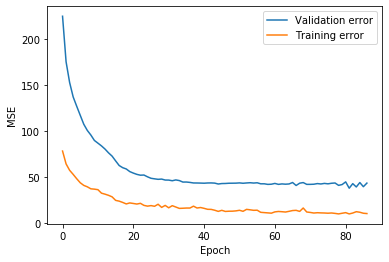

In [28]:
validation_loss
plt.plot(validation_loss)
plt.plot(training_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(['Validation error', 'Training error'])
plt.show()

In [30]:
# FFNN
# RNN for single user start - drop off
class FFNNet(nn.Module):
    def __init__(self, hidden_size):
        super(FFNNet, self).__init__()
        self.hidden_size = 250
        
        self.linear1 = nn.Linear(matrix_size, self.hidden_size)
        
        self.linear2 = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.l_out = nn.Linear(self.hidden_size, matrix_size)
        
    def forward(self, input_seq):
        hidden = self.linear1(input_seq)
        hidden2 = self.linear2(hidden)
        output = F.relu(self.l_out(hidden))
        return output
    
ffnet = FFNNet(hidden_size)
print(ffnet)

FFNNet(
  (linear1): Linear(in_features=121, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=250, bias=True)
  (l_out): Linear(in_features=250, out_features=121, bias=True)
)


In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnet.parameters(), lr=0.0001)

ff_epochs = 64

training_loss, validation_loss = [], []

for i in range(ff_epochs):
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    ffnet.eval()
    
    for inputs in test_set:
        input_m = inputs[0][0]
        output_m = inputs[1]
        
        output = ffnet(input_m)
        optimizer.zero_grad()
        loss = criterion(output, output_m)
        
        epoch_validation_loss += loss.detach().numpy()
        
    ffnet.train()
    
    for inputs in train_set:
        
        input_m = inputs[0][0]
        output_m = inputs[1]
        
        output = ffnet(input_m)
        optimizer.zero_grad() 
        loss = criterion(output, output_m)
       
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.detach().numpy()
        
    training_loss.append(epoch_training_loss/len(train_set))
    validation_loss.append(epoch_validation_loss/len(test_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch 0, training loss: 66.8390669165938, validation loss: 203.57150077819824
Epoch 5, training loss: 48.52280165862154, validation loss: 100.44202596491033
Epoch 10, training loss: 47.78279921522847, validation loss: 100.36062518033114
Epoch 15, training loss: 47.162713336171926, validation loss: 100.34985559636897
Epoch 20, training loss: 46.581651636847745, validation loss: 100.37701797485352
Epoch 25, training loss: 43.98986055619187, validation loss: 97.03243255615234
Epoch 30, training loss: 43.333713678298174, validation loss: 97.1035253351385
Epoch 35, training loss: 42.7730861251001, validation loss: 97.07859143343839
Epoch 40, training loss: 42.24997615814209, validation loss: 97.16802701083097
Epoch 45, training loss: 41.75876800219218, validation loss: 97.28585676713423
Epoch 50, training loss: 41.29583417375883, validation loss: 97.44129007512873
Epoch 55, training loss: 40.86440830650153, validation loss: 97.63630710948597
Epoch 60, training loss: 40.46403141154183, valid

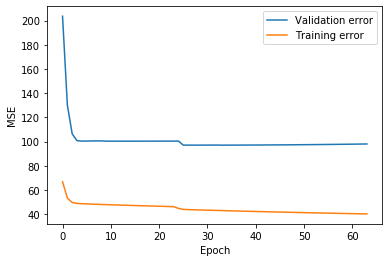

In [32]:
validation_loss
plt.plot(validation_loss)
plt.plot(training_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(['Validation error', 'Training error'])
plt.show()

In [33]:
cropped_target_matrices.shape

torch.Size([162, 121])

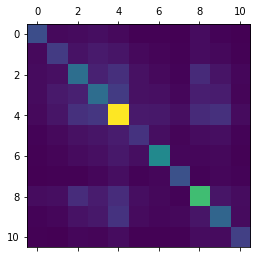

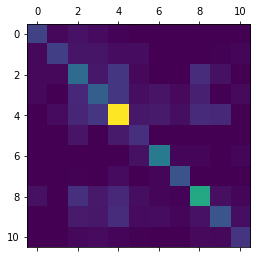

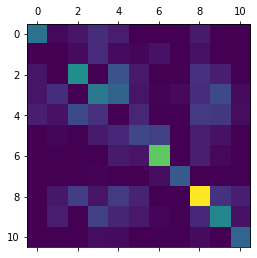

In [41]:
# Mean Matrix
crop_mean = cropped_target_matrices.mean(axis=0)
plt.matshow(crop_mean.reshape(11,11))

# LSTM Matrix
# Making predicitions
with torch.no_grad():
    net.hidden = (torch.zeros(1, 1, hidden_size),
                    torch.zeros(1, 1, hidden_size))

    lstm_prediction = net(train_set[50][0])
plt.matshow(prediction.reshape(11, 11))

# FFNN Matrix
# Making predicitions
with torch.no_grad():
    ffn_prediction = ffnet(train_set[50][0])
# ffn_prediction[0].shape
plt.matshow(ffn_prediction[0].reshape(11,11))

In [91]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
print(lstm_prediction)
print(ffn_prediction[0])

tensor([[9.7163e+00, 1.5510e+00, 2.2239e+00, 1.5400e+00, 8.3634e-01, 1.3107e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3376e-01,
         8.8157e+00, 2.5179e+00, 2.4843e+00, 1.8465e+00, 1.6647e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.7610e-01, 5.6201e-01, 9.9748e-01, 1.6266e+00,
         1.7496e+01, 3.1433e+00, 7.2636e+00, 1.2848e+00, 0.0000e+00, 0.0000e+00,
         6.3792e+00, 2.4713e+00, 0.0000e+00, 1.1969e+00, 0.0000e+00, 5.1481e+00,
         1.5000e+01, 7.8689e+00, 1.8833e+00, 2.4135e+00, 9.7675e-01, 4.1293e+00,
         0.0000e+00, 1.2313e+00, 0.0000e+00, 1.6925e+00, 5.8281e+00, 8.1092e+00,
         4.9188e+01, 2.9981e+00, 3.3355e+00, 1.7679e+00, 6.0534e+00, 5.6922e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4041e+00, 0.0000e+00, 3.5666e+00,
         6.8083e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6305e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2974e+00,
         2.0097e+01, 7.1190e

In [53]:
[print(word, end='') for word in input('Įveskite savo vardą ir pavardę:').split()]

Įveskite savo vardą ir pavardę:monka s
monkas

[None, None]